In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

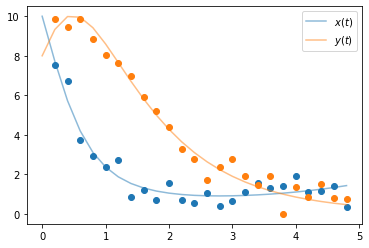

In [20]:
def ODE(xy, t, p):
    gamma = 1
    dx = (p[0] - p[1]*xy[1])*xy[0]
    dy = (-gamma + p[2]*xy[0])*xy[1]
    return [dx, dy]

times = np.arange(0, 5, 0.2)

alpha, beta, delta = 0.45, 0.2, 0.2

# Create true curves

y = odeint(ODE, t=times, y0=[10, 8], args=((alpha, beta, delta),))

yobs = np.clip(np.random.normal(loc = y[1::], scale = 0.5), a_min = 0, a_max = None)

plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C0", alpha=0.5, label=f"$x(t)$")
plt.plot(times, y[:, 1], color="C1", alpha=0.5, label=f"$y(t)$")
plt.legend()
plt.show()

In [21]:
LV_ode = DifferentialEquation(
    func=ODE,
    times=np.arange(0.2, 5, 0.2), # не включаем начальную точку
    n_states=2, # Размерность системы ОДУ 
    n_theta=3, # Размерность вектора параметров
    t0=0,
)

In [22]:
with pm.Model() as LVmodel:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)
    alpha = pm.Uniform("alpha", 0.1, 1.0)
    beta = pm.Uniform("beta", 0.1, 1.0)
    delta = pm.Uniform("delta", 0.1, 1.0)

    LV_curves = LV_ode(y0=[10, 8], theta=[alpha, beta, delta])

    Y = pm.Normal("Y", mu=LV_curves, sigma=sigma, observed=yobs)

    trace = pm.sample(100, tune=50, target_accept=0.9, cores=1)
    data = az.from_pymc3(trace=trace)

<ipython-input-22-566fca06f3b3>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(100, tune=50, target_accept=0.9, cores=1)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [delta, beta, alpha, sigma]


Sampling 2 chains for 50 tune and 100 draw iterations (100 + 200 draws total) took 186 seconds.
The acceptance probability does not match the target. It is 0.9615055066429374, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


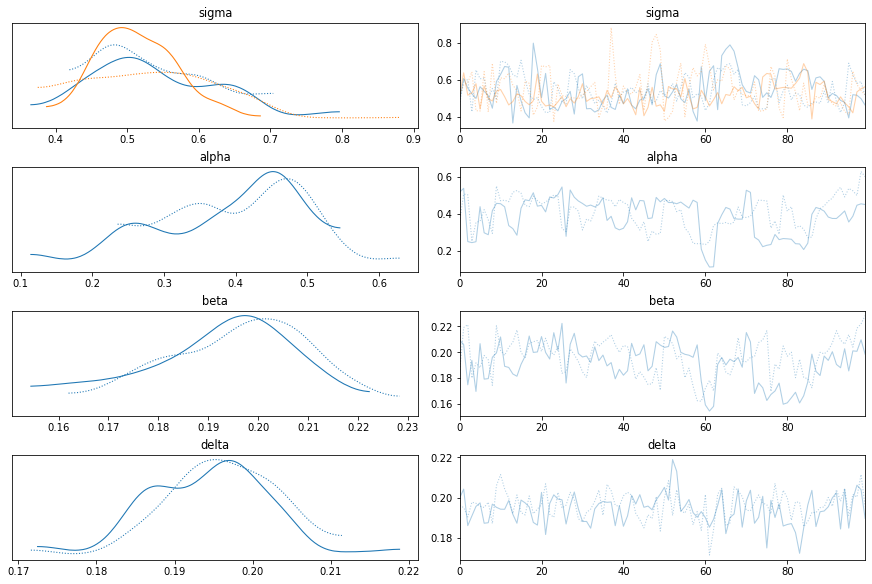

In [23]:
with LVmodel:
    az.plot_trace(trace)

array([[<AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'delta'}>, <AxesSubplot:>]],
      dtype=object)

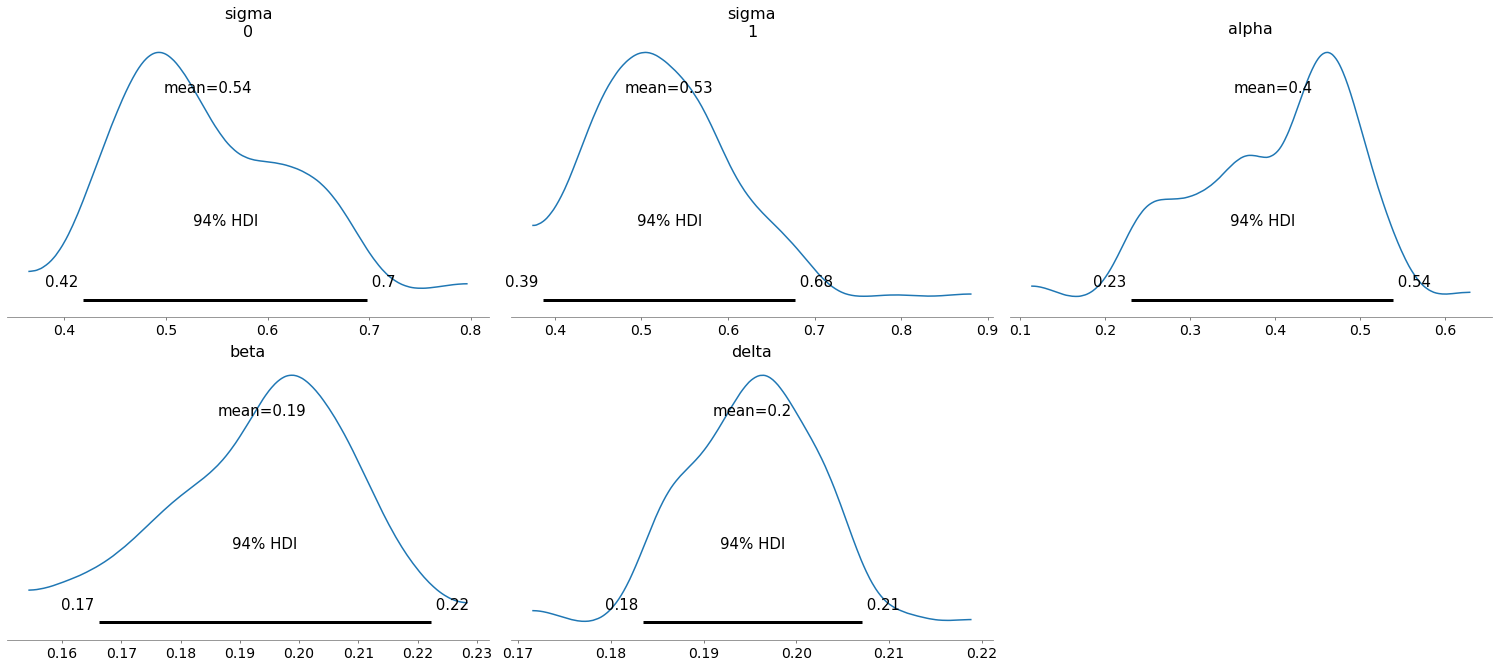

In [24]:
az.plot_posterior(data, round_to=2)